In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits

from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.patches import Circle

from scoobscc.math_module import xp, xcipy, ensure_np_array
from scoobscc import utils
from scoobscc import dm
from scoobscc import iefc_sim as iefc
import scoobscc.scoob_model as scoobm

wfe_data = utils.load_pickle('/home/derbyk/src/scoob-scc/data_sim/example_wfe_data.pkl')

Oversampling > 2x suggested for reliable results in Fresnel propagation.


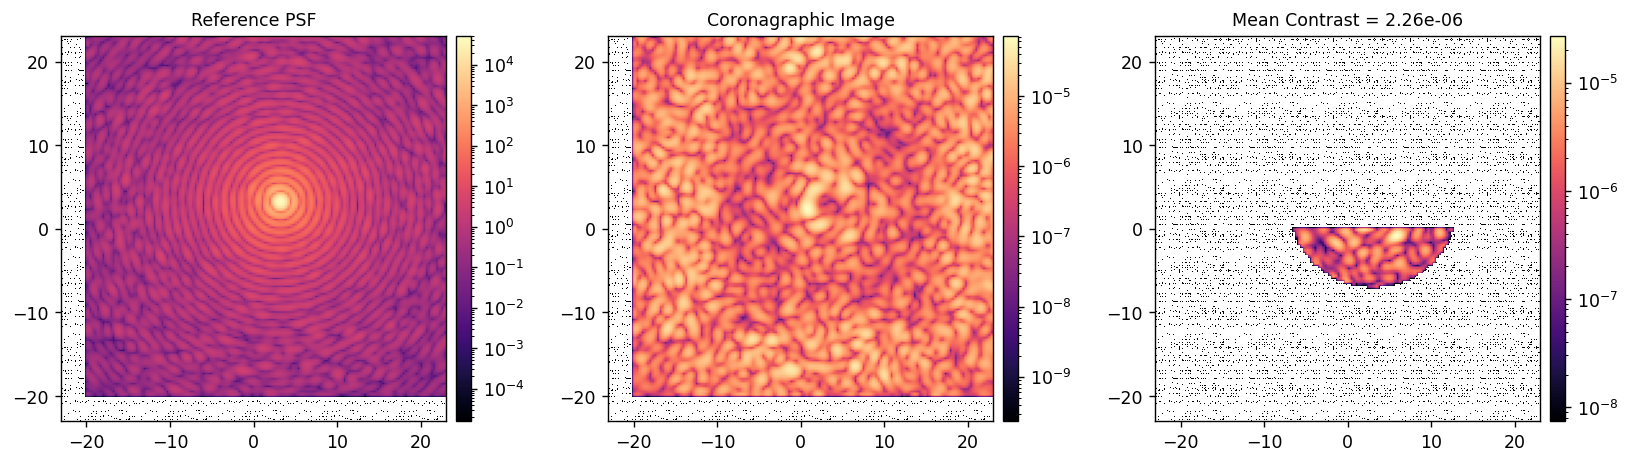

In [2]:
reload(scoobm)
reload(utils)

M = scoobm.single()
M.ncamsci = 150
M.camsci_shear = (10, 10)

M.PREFPM_AMP = wfe_data['PREFPM_AMP']
M.PREFPM_OPD = wfe_data['PREFPM_OPD']

M.POSTFPM_AMP = wfe_data['POSTFPM_AMP']
M.POSTFPM_OPD = wfe_data['POSTFPM_OPD']

M.RLS_AMP = wfe_data['RLS_AMP']
M.RLS_OPD = wfe_data['RLS_OPD']

M.dm_ref = wfe_data['DM_FLAT']
M.reset_dm()

iwa = 3
owa = 10
# control_mask = utils.create_annular_focal_plane_mask(
control_mask = utils.create_annular_mask(
    M.ncamsci, 
    M.camsci_pxscl_lamD, 
    iwa, 
    owa,  
    edge=iwa,
    x_shift=10,
    y_shift=10,
    rotation=90,
)
# imshow1(control_mask, pxscl=M.camsci_pxscl_lamD)

M.use_vortex = 0
ref_psf = M.snap_camsci()
M.Imax_ref = xp.max(ref_psf)

M.use_vortex = 1
camsci_im0 = M.snap_camsci()
mean_contrast0 = xp.mean(camsci_im0[control_mask])

utils.imshow(
    [ref_psf, camsci_im0, camsci_im0*control_mask],
    titles=['Reference PSF', 'Coronagraphic Image', f'Mean Contrast = {mean_contrast0:.2e}'], 
    pxscls=3*[M.camsci_pxscl_lamDc],
    norms=[LogNorm(), LogNorm(), LogNorm()], 
)





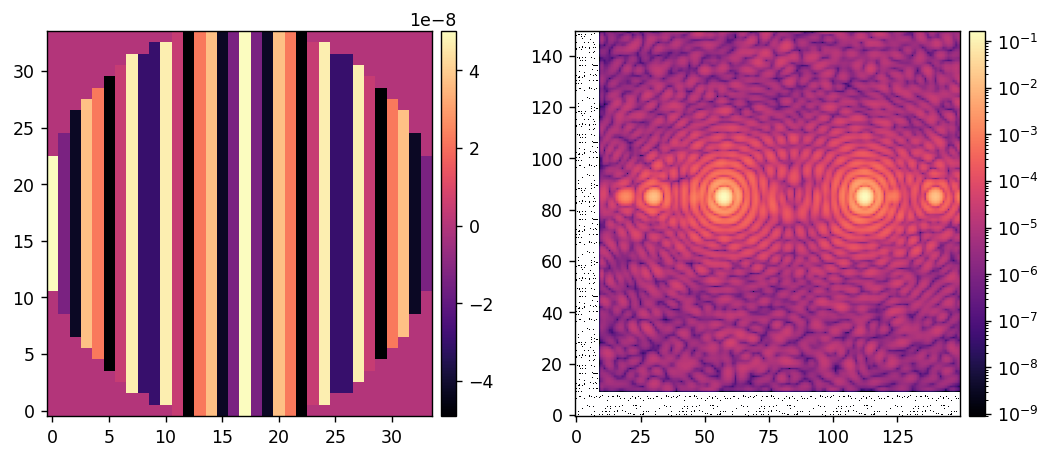

In [3]:
reload(dm)
reload(utils)
command = 50e-9 * dm.make_fourier_command(10,0) * M.dm_mask
M.set_dm(command)
im = M.snap_camsci()
utils.imshow([command, im], norms=[None, LogNorm()])

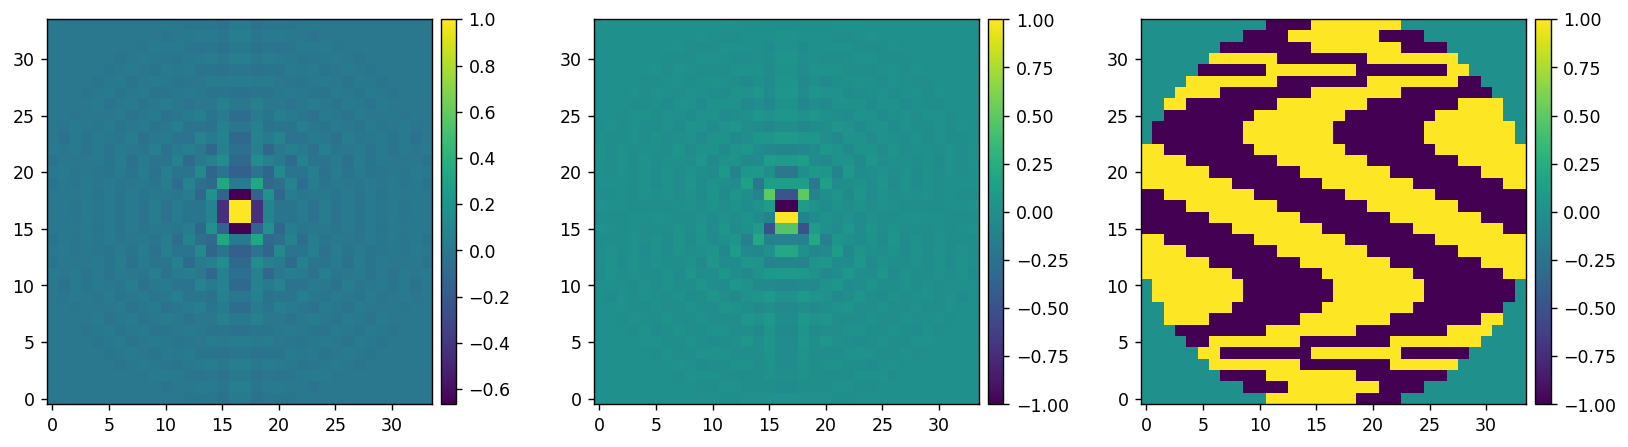

In [4]:
reload(utils)
reload(dm)
fourier_probes = dm.create_fourier_probes(
    M.dm_mask, 
    M.ncamsci, 
    M.camsci_pxscl_lamDc, 
    2, 
    15, 
    # iwa-1, 16, 
    rotation=90,
    use_weighting=True,
    nprobes=2,
)

calib_modes = dm.create_hadamard_modes(M.dm_mask)

utils.imshow([fourier_probes[0], fourier_probes[1], calib_modes[8]], cmaps=3*['viridis'])

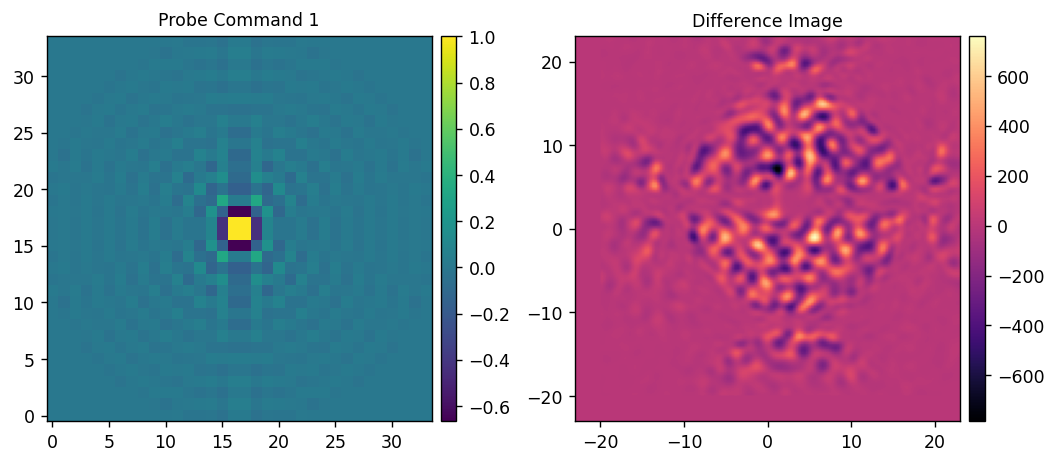

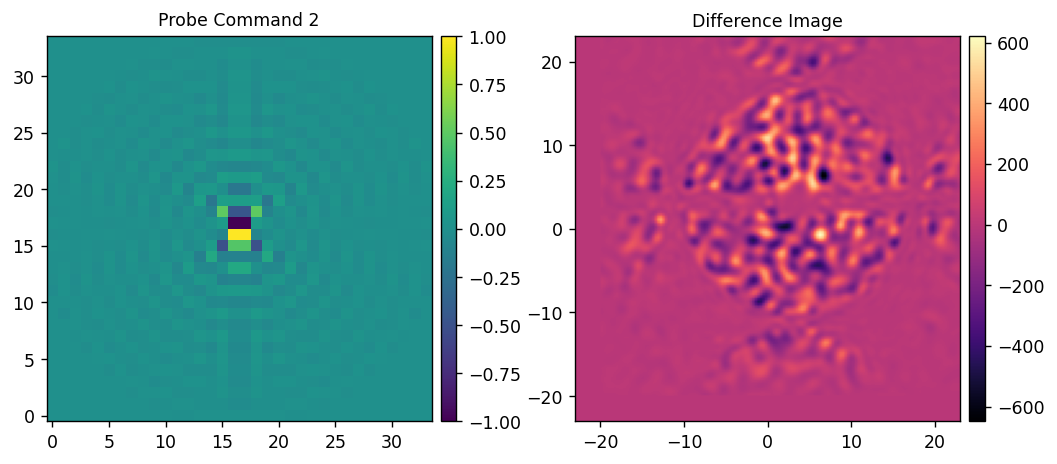

In [5]:
reload(iefc)
M.reset_dm()

diff_ims = iefc.take_measurement(
    M, 
    fourier_probes,
    2e-9,
    channel=3,
    plot=1,
)

Calibrating iEFC...
	Calibrated mode 1024/1024 in 123.448s
Calibration complete.


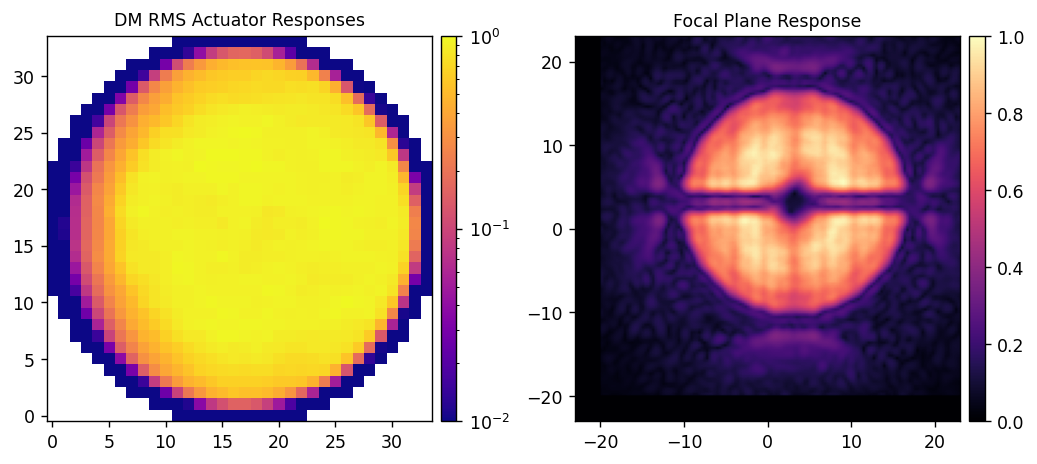

In [6]:
reload(iefc)
M.reset_dm()

probe_amp = 1e-9
calib_amp = 1e-9

response_matrix, response_cube = iefc.calibrate(
    M, 
    control_mask, 
    probe_amp, 
    fourier_probes, 
    calib_amp, 
    calib_modes[:], 
    plot_responses=True,
    channel=3,
)

In [7]:
reload(utils)
cm20 = utils.beta_reg(response_matrix, -2)
cm25 = utils.beta_reg(response_matrix, -2.5)
cm30 = utils.beta_reg(response_matrix, -3)
cm35 = utils.beta_reg(response_matrix, -3.5)
cm40 = utils.beta_reg(response_matrix, -4)
cm45 = utils.beta_reg(response_matrix, -4.5)
cm50 = utils.beta_reg(response_matrix, -5)

In [10]:
M.reset_dm()
data = {
    'images':[camsci_im0],
    'contrasts':[mean_contrast0],
    'commands':[],
    'del_commands':[],
    'pixelscale':M.camsci_pxscl_lamD,
    'control_mask':control_mask, 
    'probes':fourier_probes,
}

Running iEFC...
	Closed-loop iteration 25 / 27


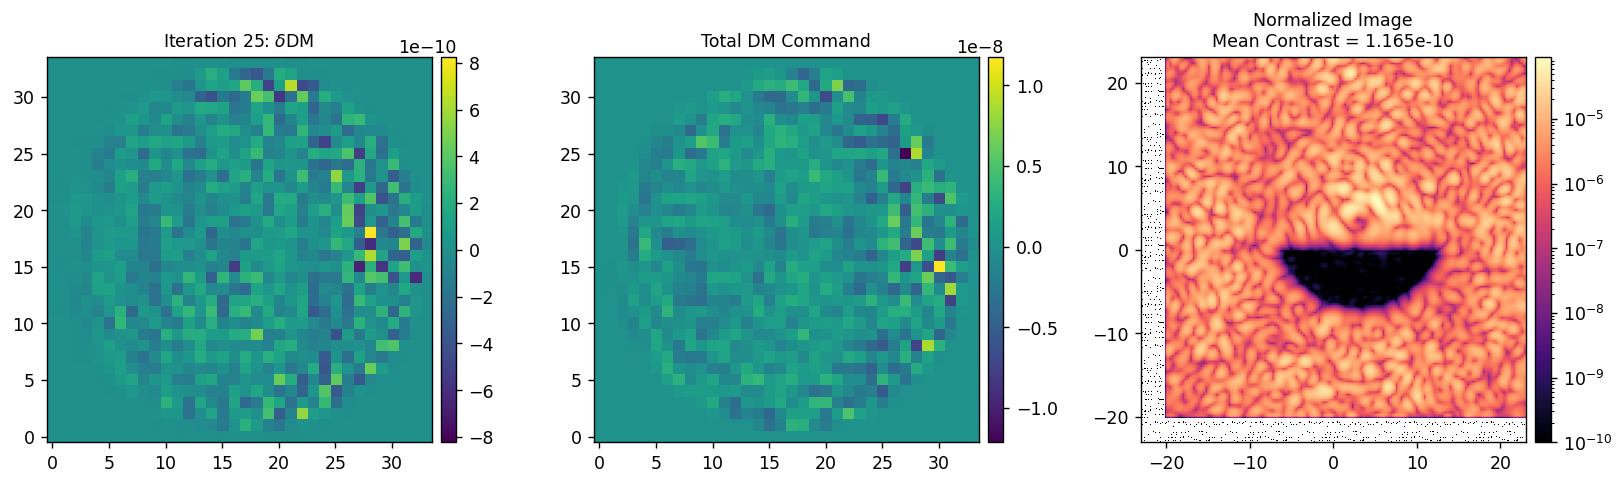

	Closed-loop iteration 26 / 27


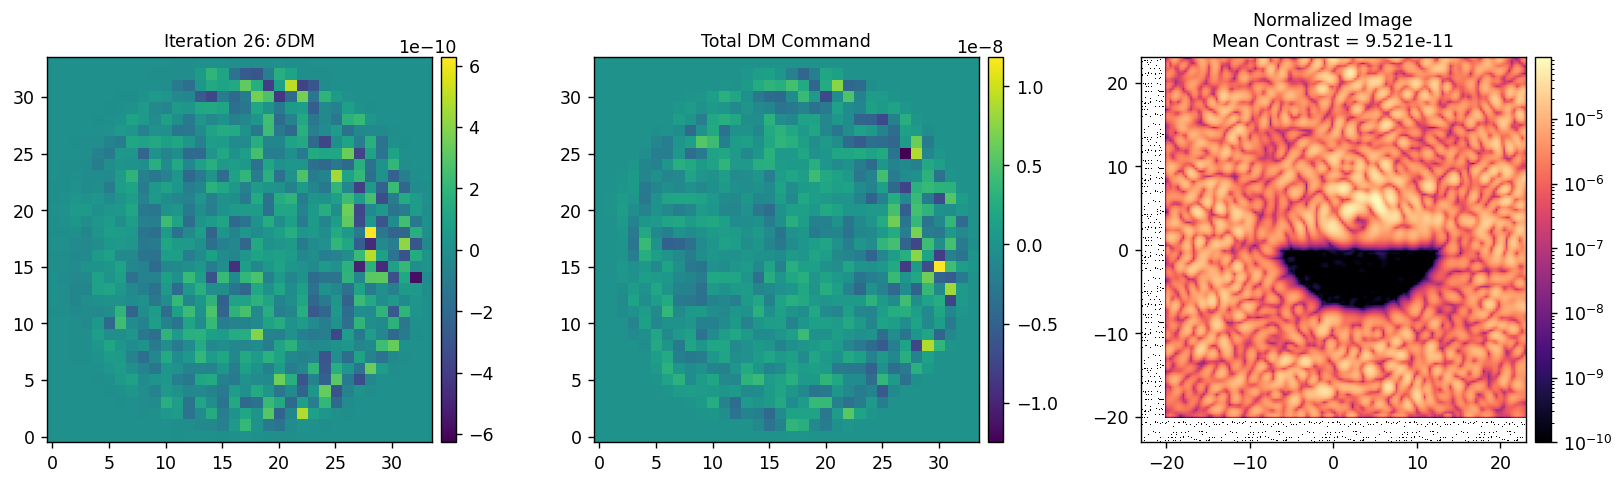

	Closed-loop iteration 27 / 27


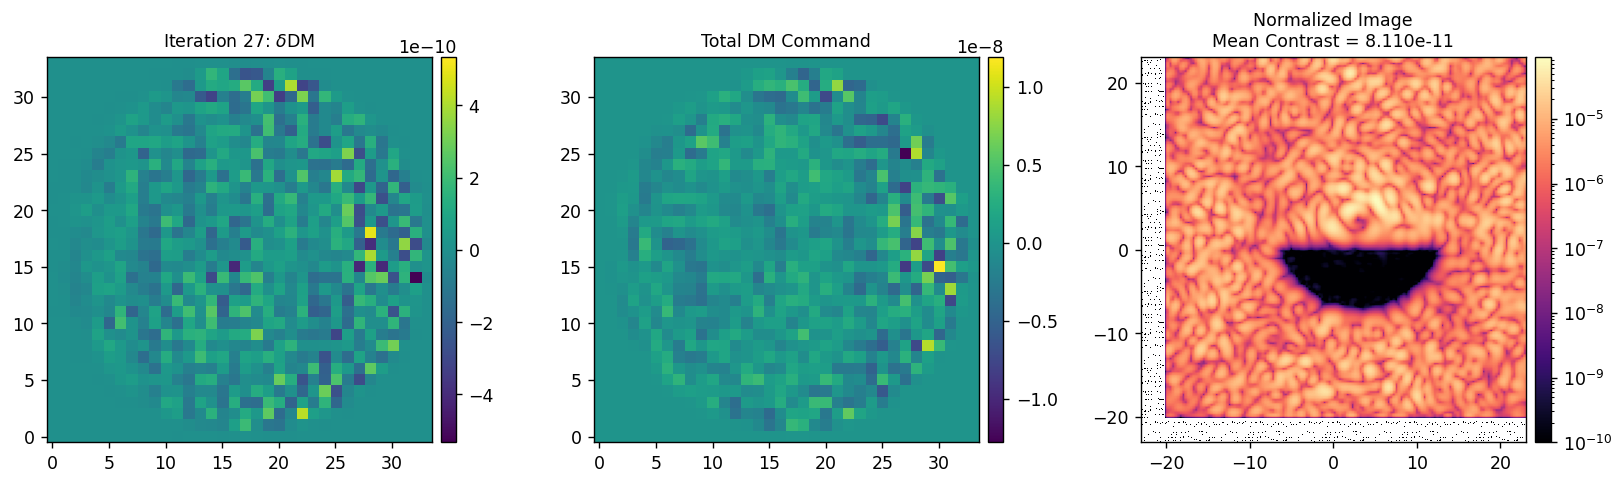

Closed loop for given control matrix completed in 2.469s.


In [19]:
reload(utils)
reload(iefc)

probe_amp = 2.5e-9
probe_amp = 1e-9
probe_amp = 0.25e-9

data = iefc.run(
    M,
    data,
    # cm20,
    # cm25,
    cm40,
    # cm45,
    # cm50,
    fourier_probes, 
    probe_amp, 
    calib_modes,
    control_mask,
    channel=3,
    num_iterations=3,
    gain=1, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    plot_probes=False,
    vmin=1e-10,
)